## Código PySpark (Notebook Jupyter)

### Instalação do PySpark e de outras bibliotecas associadas

In [47]:
import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

# **Sessão PySpark**

In [48]:
#Criação de uma sessão Spark.
spark = SparkSession.builder.appName("Análise Criptomoeda BitCoin").getOrCreate()

In [49]:
#Bibliotecas necessárias à execução do script.
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, lag, sum as spark_sum
from pyspark.sql.functions import year, month, day
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.window import Window
from pyspark.sql.functions import year, month, day
from pyspark.sql.functions import col, when, lag, sum as spark_sum
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier, DecisionTreeClassifier
from xgboost import XGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
#Acesso ao dataset a partir do qual se desenvolver a análise relativa à criptomoeda BitCoin.
path = './../exemplos/data/btc1d_usdt.csv'
df = spark.read.csv(path, header=True, inferSchema=True)
df.show()

+---+-------------------+-------+-------+-------+-------+-----------+--------------------+----------------+------+--------------+----------------+------+-------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+-----------------+------------------+------------------+--------------+------------------+------------------+------------------+------------------+---------------+---------------+-----------------+------------------+------------------+------------------+-------------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------------+------------------+------------------+----------+-----------------+---------------+------------------+--------------+------------------+--------------+--------------------+--------------------+---------------------+----------+----------------+------------------+------------------+------------------+---------

In [51]:
#Forma do dataframe em análise.
num_rows = df.count()
num_cols = len(df.columns)
print(f"Shape: ({num_rows}, {num_cols})")
#Linhas: 2452 | Colunas: 109

Shape: (2452, 109)


In [52]:
#Análise estatística básica referente às principais colunas do dataframe.
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+--------------------+------------------+------------------+--------------------+------+-------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+-------

In [53]:
#Criação de um dataframe relativo à cotação de fecho da BitCoin.
df_close = df.select('close').toPandas()  # Convertendo para Pandas DataFrame para visualização

# **Preparação dos dados**

In [54]:
#Exibição dos nomes das colunas a eliminar.
print("Colunas antes de remover:", df.columns)

Colunas antes de remover: ['_c0', 'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_vol', 'trades', 'taker_buy_base', 'taker_buy_quote', 'ignore', 'symbol', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi', 'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_kchi', 'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 

In [55]:
#Remoção de colunas indesejadas (Não acrescentam valor à análise).

#Definir a lista de nomes de colunas a eliminar.
columns_to_drop = ['_c0', 'ignore']

#Eliminar as colunas especificadas na lista.
df = df.drop(*columns_to_drop)

In [56]:
#Verificação de valores ausentes.
df.select([col for col in df.columns if df.filter(col + ' is NULL').count() > 0]).show()

#Substituir valores ausentes por zero.
df = df.na.fill(0)

#Apresentação das 20 primeiras linhas do dataframe agora já sem valores nulos.
df.show()

+------------------+-------------------+--------------------+--------------------+-----------------+------------------+--------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------+--------------+-----------------+-----------------+------------------+------------------+----------+-----------------+---------------+------------------+--------------+------------------+--------------+--------------------+--------------------+---------------------+----------+----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+----------------+---------+-------------------+-----------------------+--------------+----------------+---------------+------------------+---------------+-----------------+------------------+--------------------+--------------------+------------+-----------+-----------------+---------------------+-------------------+----------

In [57]:
#Filtrar dados irrelevantes.

#Remover linhas onde o preço de encerramento da cotação é zero.
df = df.filter(df.close > 0)
#Não irá ser feita qualquer operação sobre o dataframe (cotação de encerramento 'close' é sempre superior a 0).

In [58]:
df.dtypes

[('open_time', 'timestamp'),
 ('open', 'double'),
 ('high', 'double'),
 ('low', 'double'),
 ('close', 'double'),
 ('volume', 'double'),
 ('close_time', 'timestamp'),
 ('quote_vol', 'double'),
 ('trades', 'int'),
 ('taker_buy_base', 'double'),
 ('taker_buy_quote', 'double'),
 ('symbol', 'string'),
 ('volume_adi', 'double'),
 ('volume_obv', 'double'),
 ('volume_cmf', 'double'),
 ('volume_fi', 'double'),
 ('volume_em', 'double'),
 ('volume_sma_em', 'double'),
 ('volume_vpt', 'double'),
 ('volume_vwap', 'double'),
 ('volume_mfi', 'double'),
 ('volume_nvi', 'double'),
 ('volatility_bbm', 'double'),
 ('volatility_bbh', 'double'),
 ('volatility_bbl', 'double'),
 ('volatility_bbw', 'double'),
 ('volatility_bbp', 'double'),
 ('volatility_bbhi', 'double'),
 ('volatility_bbli', 'double'),
 ('volatility_kcc', 'double'),
 ('volatility_kch', 'double'),
 ('volatility_kcl', 'double'),
 ('volatility_kcw', 'double'),
 ('volatility_kcp', 'double'),
 ('volatility_kchi', 'double'),
 ('volatility_kcli', 'do

In [59]:
#Alterar o tipo de dados associados à coluna 'open_time', conversão de timestamp para date.
df = df.withColumn("open_time", col("open_time").cast("date"))

In [60]:
#Adição das colunas "Year", "Month" e "Day".
df = df.withColumn("year", year(col("open_time")))
df = df.withColumn("month", month(col("open_time")))
df = df.withColumn("day", day(col("open_time")))
df = df.withColumn("is_quarter_end", when(col("month") % 3 == 0, 1).otherwise(0))
df = df.withColumn("open-close", col("open") - col("close"))
df = df.withColumn("low-high", col("low") - col("high"))
#cCalculo da coluna 'target'.
window = Window.orderBy("open_time")
df = df.withColumn("next_close", lag(col("close"), -1).over(window))
df = df.withColumn("target", when(col("next_close") > col("close"), 0).otherwise(1))

In [61]:
df.toPandas().describe()

open          high           low         close         volume  \
count   2452.000000   2452.000000   2452.000000   2452.000000    2452.000000   
mean   22692.072455  23269.572194  22054.518883  22713.707993   71688.675028   
min     3188.010000   3276.500000   2817.000000   3189.020000     228.108068   
25%     8134.122500   8307.345000   7866.690000   8136.405000   29557.721720   
50%    16955.350000  17216.355000  16678.915000  16963.370000   45880.227003   
75%    35401.940000  36462.750000  33949.500000  35408.710000   76002.932349   
max    73072.400000  73777.000000  71333.310000  73072.410000  760705.362783   
std    17536.132487  17978.844233  17036.925008  17550.325735   82932.251186   

                          close_time     quote_vol        trades  \
count                           2452  2.452000e+03  2.452000e+03   
mean   2020-12-25 11:59:25.453645056  1.671795e+09  1.458687e+06   
min       2017-08-17 23:59:59.999000  9.778657e+05  2.153000e+03   
25%    2019-04-22 17:59:59.999000064  2.893235e+08  3.084718e+05   
50%    2020-12-25 11:59:59.999000064  8.297485e+08  8.235805e+05   
75%    2022-08-30 05:59:59.999000064  2.418677e+09  1.641484e+06   
max       2024-05-03 23:59:59.999000  1.746531e+10  1.522359e+07   
std                              NaN  2.042856e+09  1.956928e+06   

       taker_buy_base  taker_buy_quote  ...      slope_obv    slope_rsi  \
count     2452.000000     2.452000e+03  ...    2452.000000  2452.000000   
mean     35658.282648     8.287237e+08  ...     446.613516    -0.009564   
min         56.190141     2.413638e+05  ... -267656.007210    -4.820132   
25%      14985.579793     1.493515e+08  ...  -10265.996306    -0.924697   
50%      22745.219056     4.059852e+08  ...     321.915927     0.000000   
75%      37569.466374     1.200708e+09  ...   11708.157818     0.930839   
max     374775.574085     8.783916e+09  ...  293989.338204     5.209099   
std      41259.852187     1.015451e+09  ...   39074.985434     1.496633   

              year        month          day  is_quarter_end   open-close  \
count  2452.000000  2452.000000  2452.000000     2452.000000  2452.000000   
mean   2020.481240     6.530587    15.757341        0.336052   -21.635538   
min    2017.000000     1.000000     1.000000        0.000000 -7579.180000   
25%    2019.000000     3.000000     8.000000        0.000000  -260.662500   
50%    2020.000000     7.000000    16.000000        0.000000    -8.435000   
75%    2022.000000    10.000000    23.000000        1.000000   223.465000   
max    2024.000000    12.000000    31.000000        1.000000  7038.700000   
std       1.977447     3.515931     8.809573        0.472453  1014.407078   

           low-high    next_close       target  
count   2452.000000   2451.000000  2452.000000  
mean   -1215.053312  22721.226814     0.483279  
min   -13584.900000   3189.020000     0.000000  
25%    -1608.820000   8137.565000     0.000000  
50%     -697.850000  16966.350000     0.000000  
75%     -323.830000  35412.950000     1.000000  
max      -30.540000  73072.410000     1.000000  
std     1369.222269  17549.956659     0.499822  

[8 rows x 113 columns]

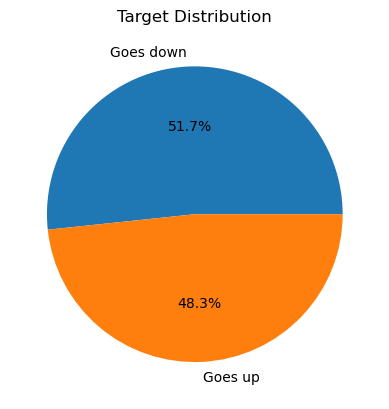

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [62]:
#Criação da variável 'colunas' que irá estar associada aos nomes das colunas do dataframe.

#Obter a lista de colunas atuais.
cols = df.columns

# Definir a nova ordem das colunas para que as novas colunas apareçam após 'close'
new_cols_order = cols[:cols.index("close") + 1] + ["year", "month", "day", "is_quarter_end", "open-close", "low-high"] + cols[cols.index("close") + 1:]

# Reorganizar as colunas no DataFrame
df_spark = df.select(*new_cols_order)

# Conversão para Pandas para criar o gráfico
df_pandas = df.toPandas()

# Criação do gráfico de pizza para a coluna 'target'
plt.pie(df_pandas['target'].value_counts().values,
        labels=["Goes down", "Goes up"], autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

# Criação de uma figura
plt.figure(figsize=(10, 10))

In [63]:
#Forma do dataframe após preparação dos dados.
num_rows = df.count()
num_cols = len(df.columns)
print(f"Shape: ({num_rows}, {num_cols})")
#Linhas: 2452 | Colunas: 115

Shape: (2452, 115)


In [64]:
# Exibir as primeiras linhas para verificar a nova coluna
df.show(5)

+----------+-------+-------+-------+-------+-----------+--------------------+----------------+------+--------------+----------------+-------+------------------+------------------+----------+---------+--------------------+-------------+-------------------+-----------+----------+------------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+--------------+------------------+-----------------+--------------+------------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+----------+-----------------+---------------+--------------+--------------+--------------+--------------+--------------------+--------------------+---------------------+----------+----------------+---------+---------+-------------+--------------+-------------------+-------------------+----------------+------------------+---------+---------+-------------+-------------+----

# **Análise Exploratória dos Dados**

**Gráficos**

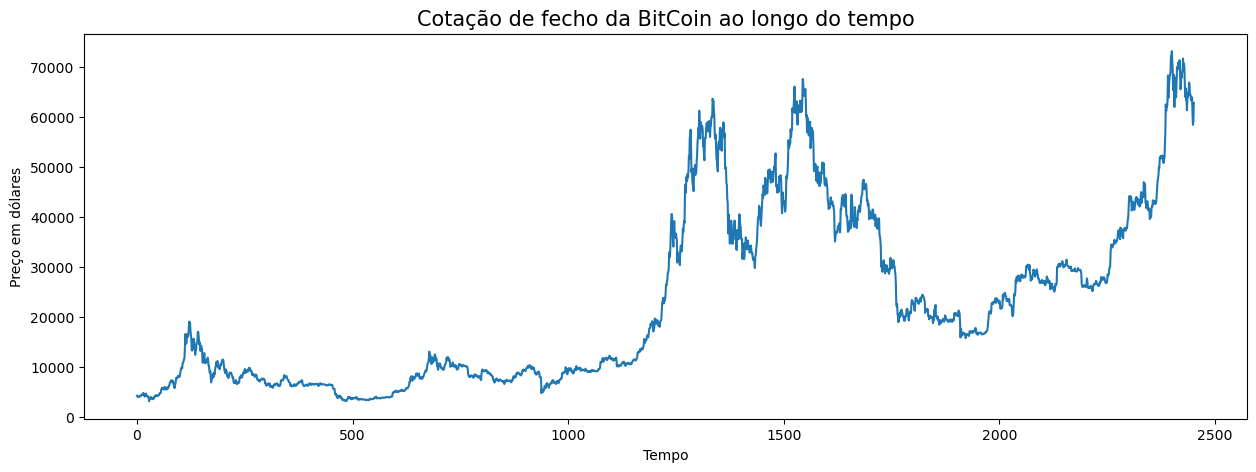

In [65]:
#Geração de um gráfico inerente à cotação da BitCoin.
df_pandas = df.select('close').toPandas()
plt.figure(figsize=(15, 5))
plt.plot(df_pandas['close'])
plt.title('Cotação de fecho da BitCoin ao longo do tempo', fontsize=15)
plt.ylabel('Preço em dólares')
plt.xlabel('Tempo')
plt.show()

In [66]:
features =  ['open_time','open', 'high', 'low', 'close', 'volume', 'trades', 'volume_obv', 'trend_ema_fast',
             'trend_ema_slow', 'momentum_rsi', 'momentum_stoch_rsi', 'others_cr', 'morningstar',
             'hammer', 'piercing', '3soldiers', 'engulfing', 'ema200', 'ema50', 'slope', 'slope_obv']

#Verificação de valores ausentes.
print("Valores nulos:")
existing_features = [f for f in features if f in df.columns]
df.select([spark_sum(col(f).isNull().cast("int")).alias(f) for f in existing_features]).show()

Valores nulos:
+---------+----+----+---+-----+------+------+----------+--------------+--------------+------------+------------------+---------+-----------+------+--------+---------+---------+------+-----+-----+---------+
|open_time|open|high|low|close|volume|trades|volume_obv|trend_ema_fast|trend_ema_slow|momentum_rsi|momentum_stoch_rsi|others_cr|morningstar|hammer|piercing|3soldiers|engulfing|ema200|ema50|slope|slope_obv|
+---------+----+----+---+-----+------+------+----------+--------------+--------------+------------+------------------+---------+-----------+------+--------+---------+---------+------+-----+-----+---------+
|        0|   0|   0|  0|    0|     0|     0|         0|             0|             0|           0|                 0|        0|          0|     0|       0|        0|        0|     0|    0|    0|        0|
+---------+----+----+---+-----+------+------+----------+--------------+--------------+------------+------------------+---------+-----------+------+--------+-----

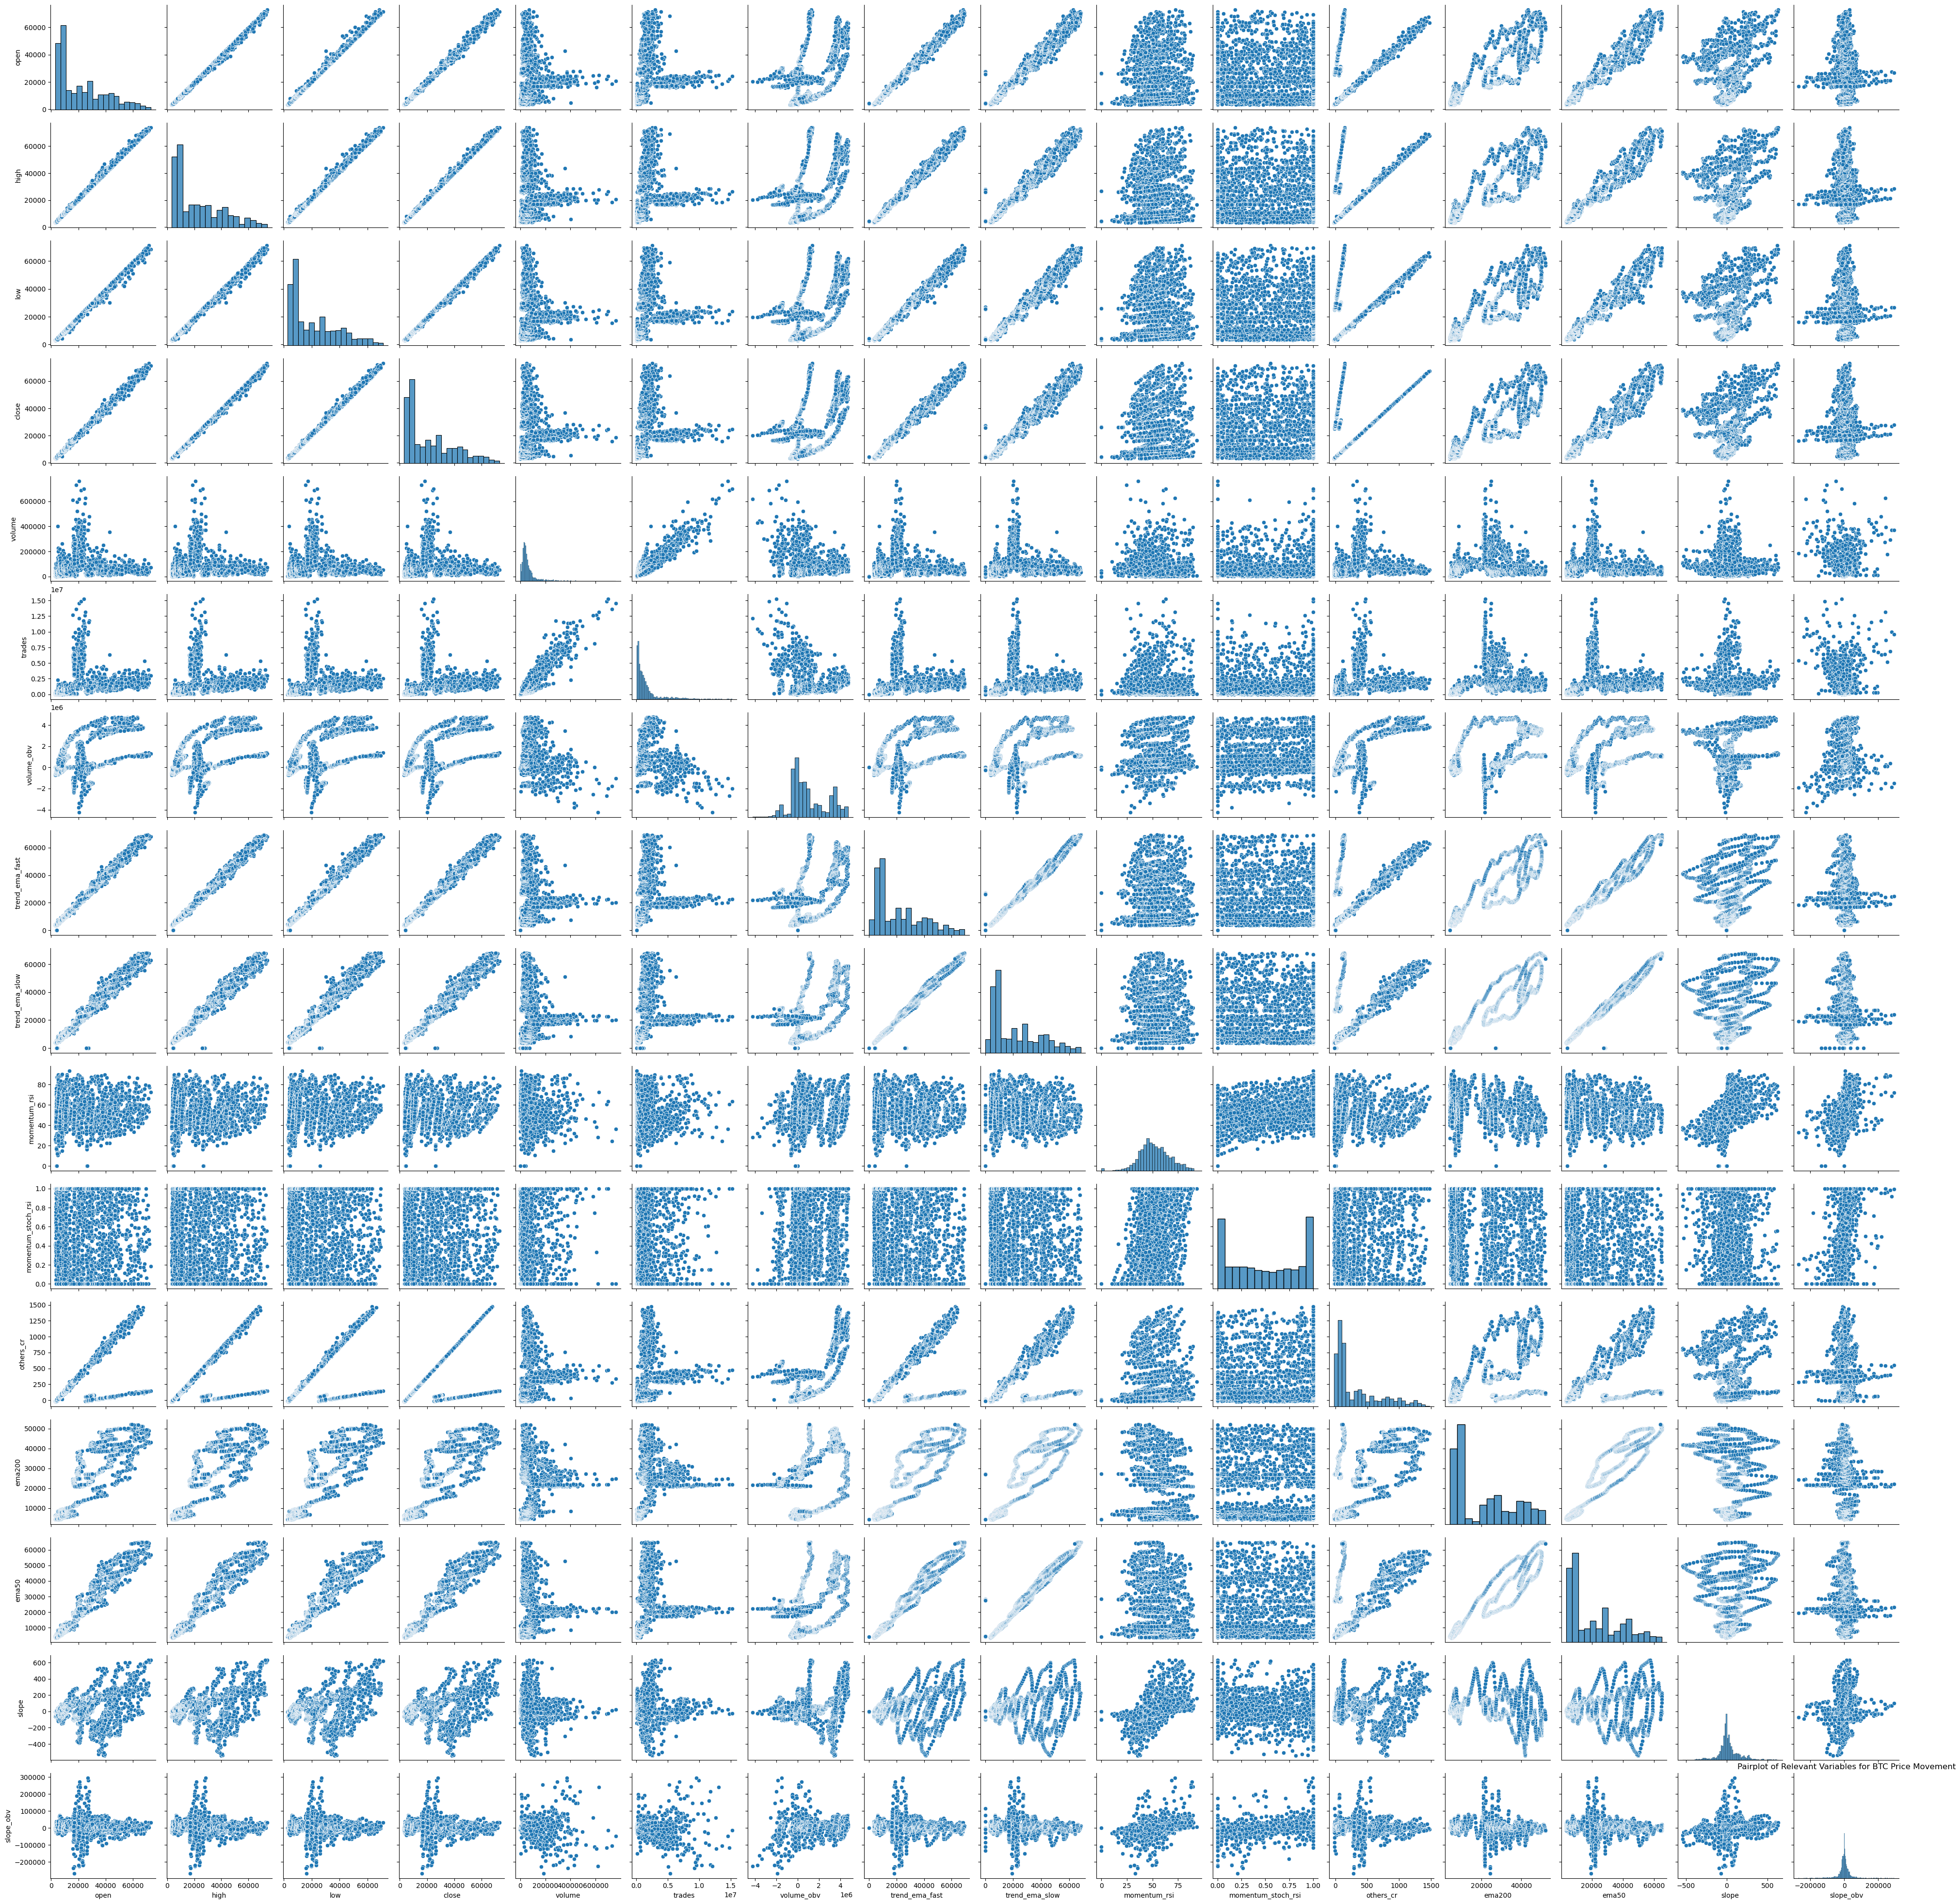

In [68]:
#Gráficos PairPlot das variáveis significativas para a cotação da BitCoin.

#Selecionar colunas específicas para PairPlot.
selected_features = existing_features[1:13] + existing_features[18:]

#Converter o DataFrame PySpark para Pandas.
df_pandas = df.select(selected_features).toPandas()

#Gráficos PairPlot que demonstram a relação existente entre as diferentes variáveis do dataframe.
sns.pairplot(df_pandas)
plt.title('Pairplot of Relevant Variables for BTC Price Movement')
plt.show()

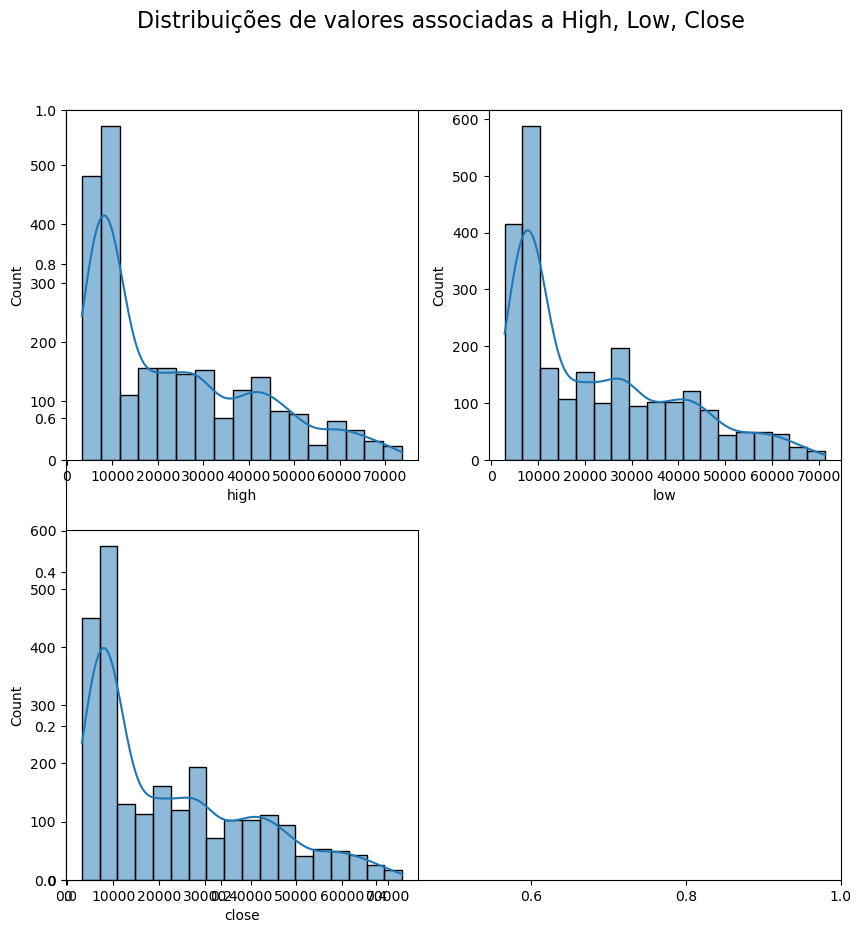

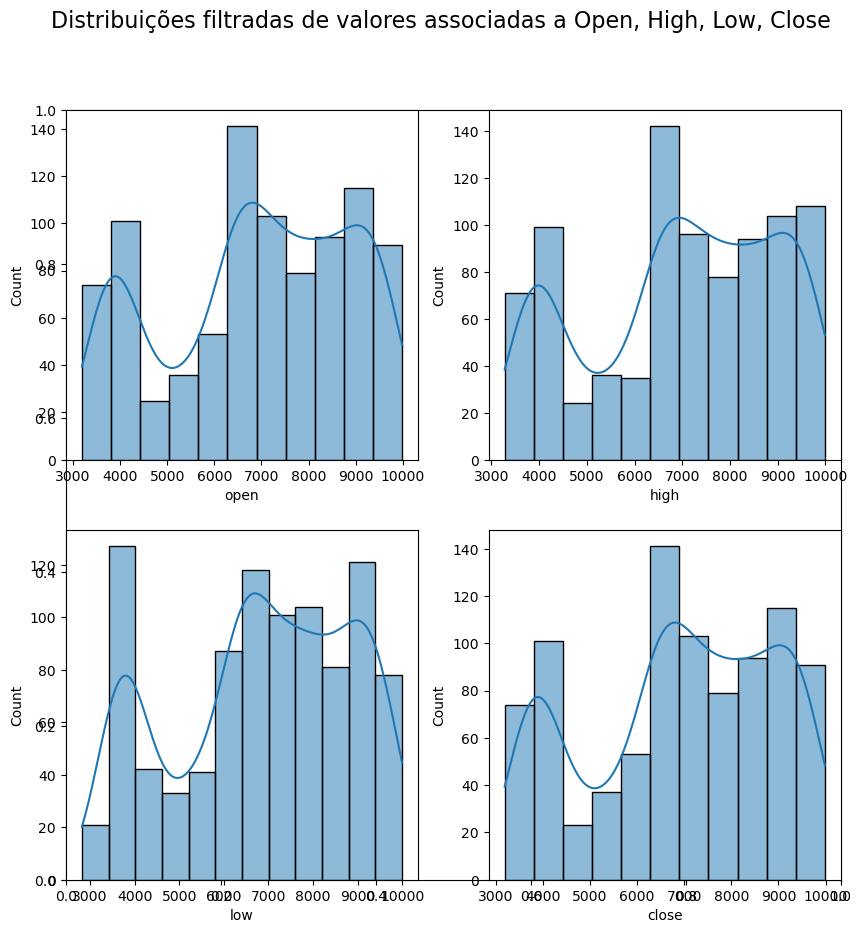

In [69]:
#Gráficos alusivos às diferentes distribuições de dados.

#Selecionar as componentes/variáveis específicas a analisar.
features = ['open', 'high', 'low', 'close']

#Converter o dataFrame PySpark para Pandas.
df_pandas = df.select(features).toPandas()

#1ºGráfico: Distribuições das colunas 'high', 'low', 'close':
plt.subplots(figsize=(10,10))
for i, col in enumerate(features[1:]):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_pandas[col], kde=True)
plt.suptitle('Distribuições de valores associadas a High, Low, Close', fontsize=16)
plt.show()

#2ºGráfico: Distribuições filtradas das colunas 'open', 'high', 'low', 'close'.
plt.subplots(figsize=(10,10))
for i, col in enumerate(features):
    range_min = 0.0
    range_max = 10000.0
    filtered_data = df_pandas[(df_pandas[col] >= range_min) & (df_pandas[col] <= range_max)][col]
    plt.subplot(2, 2, i+1)
    sns.histplot(filtered_data, kde=True)
plt.suptitle('Distribuições filtradas de valores associadas a Open, High, Low, Close', fontsize=16)
plt.show()

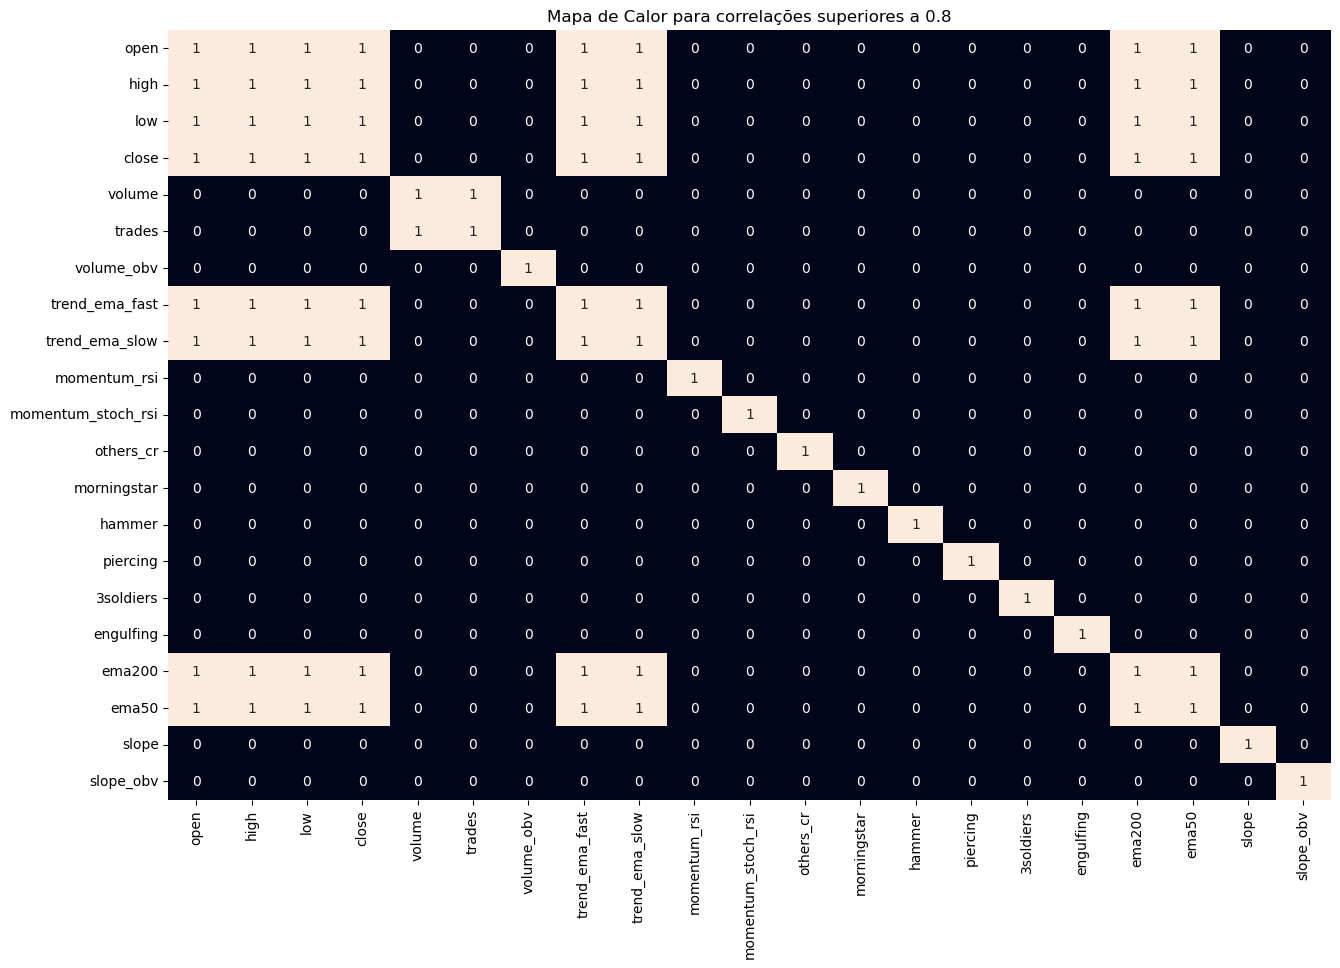

In [70]:
#Seleção das colunas relevantes para a correlação.
features = ['open', 'high', 'low', 'close', 'volume', 'trades', 'volume_obv', 'trend_ema_fast',
            'trend_ema_slow', 'momentum_rsi', 'momentum_stoch_rsi', 'others_cr', 'morningstar',
            'hammer', 'piercing', '3soldiers', 'engulfing', 'ema200', 'ema50', 'slope', 'slope_obv']

#Verificação de quais colunas existem no DataFrame.
existing_features = [f for f in features if f in df.columns]

#Criar um vetor de features.
assembler = VectorAssembler(inputCols=existing_features, outputCol="features")
df_vector = assembler.transform(df).select("features")

#Calcular a matriz de correlação.
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

#Converter a matriz de correlação para um array do Numpy.
correlation_matrix_array = correlation_matrix.toArray()

#Converter a matriz de correlação para um DataFrame Pandas.
df_corr = pd.DataFrame(correlation_matrix_array, index=existing_features, columns=existing_features)

#Criar o heatmap usando Seaborn.
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr > 0.8, annot=True, cbar=False)
plt.title('Mapa de Calor para correlações superiores a 0.8')
plt.show()

**Teste  - Modelos de Dados**

In [71]:
df.dtypes

[('open_time', 'date'),
 ('open', 'double'),
 ('high', 'double'),
 ('low', 'double'),
 ('close', 'double'),
 ('volume', 'double'),
 ('close_time', 'timestamp'),
 ('quote_vol', 'double'),
 ('trades', 'int'),
 ('taker_buy_base', 'double'),
 ('taker_buy_quote', 'double'),
 ('symbol', 'string'),
 ('volume_adi', 'double'),
 ('volume_obv', 'double'),
 ('volume_cmf', 'double'),
 ('volume_fi', 'double'),
 ('volume_em', 'double'),
 ('volume_sma_em', 'double'),
 ('volume_vpt', 'double'),
 ('volume_vwap', 'double'),
 ('volume_mfi', 'double'),
 ('volume_nvi', 'double'),
 ('volatility_bbm', 'double'),
 ('volatility_bbh', 'double'),
 ('volatility_bbl', 'double'),
 ('volatility_bbw', 'double'),
 ('volatility_bbp', 'double'),
 ('volatility_bbhi', 'double'),
 ('volatility_bbli', 'double'),
 ('volatility_kcc', 'double'),
 ('volatility_kch', 'double'),
 ('volatility_kcl', 'double'),
 ('volatility_kcw', 'double'),
 ('volatility_kcp', 'double'),
 ('volatility_kchi', 'double'),
 ('volatility_kcli', 'double'

In [72]:
df = df.dropna(subset=[
    'open', 'high', 'low', 'close', 'volume', 'trades', 'volume_obv', 'trend_ema_fast',
    'trend_ema_slow', 'momentum_rsi', 'momentum_stoch_rsi', 'others_cr', 'morningstar',
    'hammer', 'piercing', '3soldiers', 'engulfing', 'ema200', 'ema50', 'slope', 'slope_obv',
    'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high'
])

In [73]:
df.show()

+----------+-------+-------+-------+-------+-----------+--------------------+----------------+------+--------------+----------------+-------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+-----------------+------------------+------------------+--------------+------------------+------------------+------------------+------------------+---------------+---------------+-----------------+------------------+------------------+------------------+-------------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------------+------------------+------------------+----------+-----------------+---------------+------------------+--------------+------------------+--------------+--------------------+--------------------+---------------------+----------+----------------+------------------+------------------+------------------+------------------+----------

**Recomeçar a partir daqui...**
**Adicionar mais variáveis independentes ou preditoras!!**

In [74]:
df = df[['open_time'] + selected_features]

In [75]:
df.toPandas().describe()

open          high           low         close         volume  \
count   2452.000000   2452.000000   2452.000000   2452.000000    2452.000000   
mean   22692.072455  23269.572194  22054.518883  22713.707993   71688.675028   
std    17536.132487  17978.844233  17036.925008  17550.325735   82932.251186   
min     3188.010000   3276.500000   2817.000000   3189.020000     228.108068   
25%     8134.122500   8307.345000   7866.690000   8136.405000   29557.721720   
50%    16955.350000  17216.355000  16678.915000  16963.370000   45880.227003   
75%    35401.940000  36462.750000  33949.500000  35408.710000   76002.932349   
max    73072.400000  73777.000000  71333.310000  73072.410000  760705.362783   

             trades    volume_obv  trend_ema_fast  trend_ema_slow  \
count  2.452000e+03  2.452000e+03     2452.000000     2452.000000   
mean   1.458687e+06  1.047022e+06    22566.297820    22211.320427   
std    1.956928e+06  1.704930e+06    17404.651748    17270.261551   
min    2.153000e+03 -4.242190e+06        0.000000        0.000000   
25%    3.084718e+05 -1.989358e+05     8150.180364     7964.698088   
50%    8.235805e+05  5.249432e+05    16905.345594    16895.490479   
75%    1.641484e+06  2.303642e+06    34978.208705    34814.952949   
max    1.522359e+07  4.760994e+06    69328.780264    68129.924505   

       momentum_rsi  momentum_stoch_rsi    others_cr        ema200  \
count   2452.000000         2452.000000  2452.000000   2452.000000   
mean      52.226776            0.498445   321.013255  20772.326656   
std       14.717533            0.363891   367.212936  14804.250147   
min        0.000000            0.000000   -25.578519   4224.844592   
25%       42.602328            0.148507    60.257842   8155.841050   
50%       50.937976            0.486235   133.210232  13952.289568   
75%       61.630308            0.859752   490.875783  33036.654265   
max       93.460719            1.000000  1475.835924  52126.959796   

              ema50        slope      slope_obv  
count   2452.000000  2452.000000    2452.000000  
mean   22118.175830    24.524409     446.613516  
std    16702.309307   147.664193   39074.985434  
min     3678.001925  -541.380004 -267656.007210  
25%     8181.175147   -33.285443  -10265.996306  
50%    17162.433017     2.292747     321.915927  
75%    35220.758617    69.703274   11708.157818  
max    64819.906483   628.540846  293989.338204

In [76]:
from pyspark.sql.functions import lead

window = Window.orderBy("open_time") 
df = df.withColumn("next_close", lead("close", 1).over(window))

In [78]:
df.toPandas().tail()

open_time      open      high       low     close       volume  \
2447  2024-04-29  63118.62  64228.35  61765.53  63866.00  28150.22947   
2448  2024-04-30  63866.00  64734.00  59191.60  60672.00  54947.65535   
2449  2024-05-01  60672.01  60841.63  56552.82  58364.97  81166.46823   
2450  2024-05-02  58364.97  59625.00  56911.84  59060.61  47583.81961   
2451  2024-05-03  59060.60  63202.97  58811.32  62757.99  41461.52403   

       trades    volume_obv  trend_ema_fast  trend_ema_slow  momentum_rsi  \
2447  1152296  1.134159e+06    64408.449480    65240.374218     45.577210   
2448  1985671  1.079211e+06    63833.611098    64901.976128     37.910160   
2449  2401089  9.980449e+05    62992.281698    64417.753452     33.523509   
2450  1572898  1.045629e+06    62387.409129    64020.928011     35.930876   
2451  1466045  1.087090e+06    62444.421571    63927.377047     46.931245   

      momentum_stoch_rsi   others_cr        ema200         ema50      slope  \
2447            0.522856  117.008600  51796.565219  64518.071933  -3.445993   
2448            0.000000  106.155792  51884.878003  64367.245583 -22.035431   
2449            0.000000   98.316795  51949.356530  64131.862227 -50.368751   
2450            0.131409  100.680492  52020.115271  63932.989590 -78.539659   
2451            0.731878  113.243722  52126.959796  63886.911175 -96.017313   

         slope_obv  next_close  
2447  -5627.978095    60672.00  
2448  -9769.167737    58364.97  
2449 -16251.014238    59060.61  
2450 -16027.362060    62757.99  
2451 -13228.206009         NaN

In [79]:
#Janela para calcular a coluna 'target'
window = Window.orderBy("open_time")
#df = df.withColumn("next_close", lag("close", -1).over(window))
#df = df.withColumn("target", when(col("next_close") > col("close"), 0).otherwise(1))
df = df.drop("next_close")

#Seleção das features e target
assembler = VectorAssembler(inputCols=[
    'open', 'high', 'low', 'close', 'volume', 'trades', 'volume_obv', 'trend_ema_fast',
    'trend_ema_slow', 'momentum_rsi', 'momentum_stoch_rsi', 'others_cr', 'morningstar',
    'hammer', 'piercing', '3soldiers', 'engulfing', 'ema200', 'ema50', 'slope', 'slope_obv',
    'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high'
], outputCol='features')
df_features = assembler.transform(df)

#Escalonar as features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

#Seleção das features escalonadas e target
df_final = df_scaled.select(col('scaledFeatures').alias('features'), col('target').cast('integer'))

#Divisão dos dados em treino e teste
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=2022)

# Definição dos modelos
models = [
    LogisticRegression(featuresCol='features', labelCol='target'),
    LinearSVC(featuresCol='features', labelCol='target'),
    RandomForestClassifier(featuresCol='features', labelCol='target')
]

# Avaliação dos modelos
evaluator = BinaryClassificationEvaluator(labelCol='target', metricName='areaUnderROC')

for model in models:
    # Treinamento do modelo
    model = model.fit(train_data)
    # Previsão dos resultados
    predictions = model.transform(test_data)

    # Avaliação do modelo
    training_auc = evaluator.evaluate(model.transform(train_data))
    validation_auc = evaluator.evaluate(predictions)
    print(f'{model} : ')
    print('Training Accuracy : ', training_auc)
    print('Validation Accuracy : ', validation_auc)

    # Confusion Matrix
    y_true = [row['target'] for row in predictions.select('target').collect()]
    y_pred = [row['prediction'] for row in predictions.select('prediction').collect()]
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

print('\n\n0 : Goes up')
print('1 : Goes down')

IllegalArgumentException: morningstar does not exist. Available: open_time, open, high, low, close, volume, trades, volume_obv, trend_ema_fast, trend_ema_slow, momentum_rsi, momentum_stoch_rsi, others_cr, ema200, ema50, slope, slope_obv

# **Random Forest Classifier**

In [28]:
#Seleção das features e target.
assembler = VectorAssembler(inputCols=[
    'open', 'high', 'low', 'close', 'volume', 'trades', 'volume_obv', 'trend_ema_fast',
    'trend_ema_slow', 'momentum_rsi', 'momentum_stoch_rsi', 'others_cr', 'morningstar',
    'hammer', 'piercing', '3soldiers', 'engulfing', 'ema200', 'ema50', 'slope', 'slope_obv',
    'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high'
], outputCol='features')
df_features = assembler.transform(df)

#Escalonar as features.
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

#Seleção das features escalonadas e target.
df_final = df_scaled.select(col('scaledFeatures').alias('features'), col('target').cast('integer'))

#Divisão dos dados em treino e teste.
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=2022)

#Definição do modelo RandomForestClassifier.
model_rfc = RandomForestClassifier(featuresCol='features', labelCol='target')

#Treinamento do modelo.
model_rfc = model_rfc.fit(train_data)

#Previsão dos resultados.
predictions = model_rfc.transform(test_data)

#Avaliação do modelo.
evaluator = BinaryClassificationEvaluator(labelCol='target', metricName='areaUnderROC')
training_auc = evaluator.evaluate(model_rfc.transform(train_data))
validation_auc = evaluator.evaluate(predictions)
print(f'{model_rfc} : ')
print('Training Accuracy : ', training_auc)
print('Validation Accuracy : ', validation_auc)

#Matriz de Confusão.
y_true = [row['target'] for row in predictions.select('target').collect()]
y_pred = [row['prediction'] for row in predictions.select('prediction').collect()]
cm = confusion_matrix(y_true, y_pred)
print(cm)

#Exibição dos valores únicos e suas contagens.
unique_values, counts = np.unique(y_pred, return_counts=True)
print(f"y_test {np.unique(y_true, return_counts=True)}")
print(f"y_pred: \n")
print(unique_values, counts)

print('\n\n0 : Goes up')
print('1 : Goes down')

TypeError: 'str' object is not callable

In [ ]:
# Seleção das features e target
assembler = VectorAssembler(inputCols=[
    'open', 'high', 'low', 'close', 'volume', 'trades', 'volume_obv', 'trend_ema_fast',
    'trend_ema_slow', 'momentum_rsi', 'momentum_stoch_rsi', 'others_cr', 'morningstar',
    'hammer', 'piercing', '3soldiers', 'engulfing', 'ema200', 'ema50', 'slope', 'slope_obv',
    'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high'
], outputCol='features')
df_features = assembler.transform(df)

# Escalonar as features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

# Seleção das features escalonadas e target
df_final = df_scaled.select(col('scaledFeatures').alias('features'), col('target').cast('integer'))

# Divisão dos dados em treino e teste
train_data, test_data = df_final.randomSplit([0.9, 0.1], seed=2022)

# Definição do modelo DecisionTreeClassifier
model_dt = DecisionTreeClassifier(featuresCol='features', labelCol='target')

# Treinamento do modelo
model_dt = model_dt.fit(train_data)

# Previsão dos resultados
predictions = model_dt.transform(test_data)

# Avaliação do modelo
evaluator = BinaryClassificationEvaluator(labelCol='target', metricName='areaUnderROC')
training_auc = evaluator.evaluate(model_dt.transform(train_data))
validation_auc = evaluator.evaluate(predictions)
print(f'{model_dt} : ')
print('Training Accuracy : ', training_auc)
print('Validation Accuracy : ', validation_auc)

# Confusion Matrix
y_true = [row['target'] for row in predictions.select('target').collect()]
y_pred = [row['prediction'] for row in predictions.select('prediction').collect()]
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Exibição dos valores únicos e suas contagens
unique_values, counts = np.unique(y_pred, return_counts=True)
print(f"y_test {np.unique(y_true, return_counts=True)}")
print(f"y_pred: \n")
print(unique_values, counts)

print('\n\n0 : Goes up')
print('1 : Goes down')

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_d864a66e3a86, depth=5, numNodes=45, numClasses=2, numFeatures=27 : 
Training Accuracy :  0.5025508067495996
Validation Accuracy :  0.5071225071225072
[[95 22]
 [95 31]]
y_test (array([0, 1]), array([117, 126]))
y_pred: 

[0. 1.] [190  53]


0 : Goes up
1 : Goes down


**XGBClassifier**

In [ ]:
#Seleção das features e target.
assembler = VectorAssembler(inputCols=[
    'open', 'high', 'low', 'close', 'volume', 'trades', 'volume_obv', 'trend_ema_fast',
    'trend_ema_slow', 'momentum_rsi', 'momentum_stoch_rsi', 'others_cr', 'morningstar',
    'hammer', 'piercing', '3soldiers', 'engulfing', 'ema200', 'ema50', 'slope', 'slope_obv',
    'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high'
], outputCol='features')
df_features = assembler.transform(df)

#Normalizar as features.
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

#Seleção das features normalizadas e target.
df_final = df_scaled.select(col('scaledFeatures').alias('features'), col('target').cast('integer'))

#Divisão dos dados em treino e teste.
train_data, test_data = df_final.randomSplit([0.9, 0.1], seed=1)

#Converter os dados de PySpark para Pandas.
def convert_to_pandas(df):
    return pd.DataFrame(df.rdd.map(lambda row: row.asDict()).collect())

train_data_pd = convert_to_pandas(train_data.select('features', 'target'))
test_data_pd = convert_to_pandas(test_data.select('features', 'target'))

#Preparar os dados para o XGBClassifier.
X_train = np.array(train_data_pd['features'].tolist())
y_train = train_data_pd['target'].values
X_test = np.array(test_data_pd['features'].tolist())
y_test = test_data_pd['target'].values

#Treinamento do modelo XGBClassifier.
model_dt = XGBClassifier()
model_dt.fit(X_train, y_train)

#Previsão dos resultados.
y_pred = model_dt.predict(X_test)
y_train_pred = model_dt.predict_proba(X_train)[:, 1]
y_test_pred = model_dt.predict_proba(X_test)[:, 1]

#Avaliação do modelo.
training_auc = roc_auc_score(y_train, y_train_pred)
validation_auc = roc_auc_score(y_test, y_test_pred)
print(f'{model_dt} : ')
print('Training Accuracy : ', training_auc)
print('Validation Accuracy : ', validation_auc)

#Matriz de Confusão.
cm = confusion_matrix(y_test, y_pred)
print(cm)

#Exibição dos valores únicos e suas contagens.
unique_values, counts = np.unique(y_pred, return_counts=True)
print(f"y_test {np.unique(y_test, return_counts=True)}")
print(f"y_pred: \n")
print(unique_values, counts)

print('\n\n0 : Goes up')
print('1 : Goes down')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.5261591478696742
[[64 48]
 [64 50]]
y_test (array([0, 1]), array([112, 114]))
y_pred: 

[0 1] [128  98]


0 : Goes up
1 : Goes down


**XGBClassifier Kfold**

In [ ]:
#Seleção das features e target.
assembler = VectorAssembler(inputCols=[
    'open', 'high', 'low', 'close', 'volume', 'trades', 'volume_obv', 'trend_ema_fast',
    'trend_ema_slow', 'momentum_rsi', 'momentum_stoch_rsi', 'others_cr', 'morningstar',
    'hammer', 'piercing', '3soldiers', 'engulfing', 'ema200', 'ema50', 'slope', 'slope_obv',
    'year', 'month', 'day', 'is_quarter_end', 'open-close', 'low-high'
], outputCol='features')
df_features = assembler.transform(df)

#Escalonar as features.
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

#Seleção das features escalonadas e target.
df_final = df_scaled.select(col('scaledFeatures').alias('features'), col('target').cast('integer'))

#Converter os dados de PySpark para Pandas.
def convert_to_pandas(df):
    return pd.DataFrame(df.rdd.map(lambda row: row.asDict()).collect())

df_final_pd = convert_to_pandas(df_final.select('features', 'target'))

#Preparar os dados para o KFold.
X = np.array(df_final_pd['features'].tolist())
y = df_final_pd['target'].values

kf = KFold(n_splits=5, shuffle=True, random_state=2022)

#Placeholder for storing results per fold.
training_scores = []
validation_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model_dt = XGBClassifier()  # Use xgboost.XGBClassifier directly
    model_dt.fit(X_train, y_train)

    y_pred = model_dt.predict(X_test)

    training_scores.append(roc_auc_score(y_train, model_dt.predict_proba(X_train)[:,1]))
    validation_scores.append(roc_auc_score(y_test, model_dt.predict_proba(X_test)[:,1]))

    print(f"y_test {np.bincount(y_test)}")
    print(f"y_pred: \n")
    unique_values, counts = np.unique(y_pred, return_counts=True)
    print(unique_values, counts)

    cm = confusion_matrix(y_test, y_pred)
    print(cm)

# Summarize cross-validation results
print(f"Average Training Accuracy: {np.mean(training_scores):.4f}")
print(f"Average Validation Accuracy: {np.mean(validation_scores):.4f}")

y_test [266 225]
y_pred: 

[0 1] [266 225]
[[155 111]
 [111 114]]
y_test [259 232]
y_pred: 

[0 1] [271 220]
[[143 116]
 [128 104]]
y_test [247 243]
y_pred: 

[0 1] [254 236]
[[137 110]
 [117 126]]
y_test [238 252]
y_pred: 

[0 1] [274 216]
[[135 103]
 [139 113]]
y_test [257 233]
y_pred: 

[0 1] [266 224]
[[141 116]
 [125 108]]
Average Training Accuracy: 1.0000
Average Validation Accuracy: 0.5260


**Encerramento da sessão PySpark**

In [ ]:
#Stop the SparkSession.
spark.stop()

# Estrutura do trabalho
O resultado do trabalho deverá refletir os aspetos considerados relevantes para o contexto em
causa, no jupyter notebook.
Com a estrutura (utilizar markdown):
1. Introdução: Explicar o problema
2. Metodologia: como desenvolveram o trabalho, tipos de dados, transformações e filtros
realizados
3. Resultados obtidos: resultados dos algoritmos implementados
4. Conclusões: Apresentar algumas possibilidades de como é que os resultados obtidos
podem ser utilizados para resolver um problema existente



# Análise de Cotações BitCoin (BTC)

Trabalho realizado por:

* João Coelho (a22300219)
* Nelson Barra (a22311568)

# Introdução

Podem considerar os seguintes aspetos:
1. Neste tópico devem fazer um enquadramento ao trabalho;
2. De que área são, por exemplo área de negócio;
3. Que tipos de dados normalmente são utilizados;
4. Depois podem terminar a referir quais são os objetivos do trabalho.

# Metodologia

1. Devem explicar como é que vão ou aonde vão obter os dados: (1) dados foram obtidos na [Binance](http://www.binance.com) e são referentes ao preço da bitcoin diário desde 17-08-2017 até 03-05-2024; (2) os indicadores para análise técnica foram calculados com o [ta-lib](https://ta-lib.org/);  
2. Quais são as ferramentas que vão utilizar, por exemplo [Pandas][1], [PySpark][2] ou PySpark MLLib.
3. Como é que os vão trabalhar: (1) os dados foram tratados com [PySpark][2]; (2) missing values foram removidos do dataframe; (3) para processarmento com a biblioteca sklearn foram convertidos para pandas dataframes.
4. A variavel preditora valor do dia seguinte foi calculada com: df['nextday'] = df['close'].shift(-1) e definida uma variável df['updown'] = df.nextday > df.close.
5. Quais foram os algoritmos que utilizaram, e.g. Decision Tree Classifier, Random Forest Classifier, ver exemplo descrição [aqui](https://www.mdpi.com/1660-4601/18/19/10465)

* [1]: McKinney, W. (2010). Data structures for statistical computing in python. Proceedings of the 9th Python in Science Conference, 445, 51–56.
* [2]: Zaharia, M., Xin, R. S., Wendell, P., Das, T., Armbrust, M., Dave, A., Meng, X., Rosen, J., Venkataraman, S., Franklin, M. J., Ghodsi, A., Gonzalez, J., Shenker, S., & Stoica, I. (2016). Apache Spark: A Unified Engine for Big Data Processing. Commun. ACM, 59(11), 56–65. https://doi.org/10.1145/2934664

# Resultados

1. Qual é o tamanho do dataset
2. Podem explicar globalmente os dados com estatísticas descritivas por exemplo data_frame.describe().show(truncate=2) e descrevem a média (mean) e desvio padrão (stddev)  
3. Têm mais funções [aqui](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/frame.html) como por exemplo correlações data_frame.corr("col1","col2")

# Conclusões

1. Como é que podem utilizar os resultados que obtiveram
2. ...